# Imports

In [1]:
# Computational imports
import numpy as np   # Library for n-dimensional arrays
import pandas as pd  # Library for dataframes (structured data)

# Helper imports
import os 
import warnings
import pandas_datareader as web
import datetime as dt

# ML/DL imports
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)

# Reading the data

In [3]:
oil_df = pd.read_csv('oil.csv')
train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv')
sample_subm = pd.read_csv('sample_submission.csv')
holi_df = pd.read_csv('holidays_events.csv')
store_df =  pd.read_csv('stores.csv')
trans_df = pd.read_csv('transactions.csv')

train_df

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148


## train.csv
store_nbr: 제품이 판매되는 store

family: 판매된 제품의 유형

sales: 주어진 날짜, 특정 상점에서의 제품군의 총 매출

onpromotion: 지정된 날짜에 상점에서 프로모션 중 이던 제품군의 총 항목 수
## test.csv
test 데이터의 날짜는 train 데이터의 마지막 날짜 이후 15일
## stores.csv
city, state, type, cluster를 포함한 metadata
## oil.csv
일일 유가. train, test 데이터 시간 프레임의 값을 모두 포함
## transaction.csv
store 당 일별 transaction
## holidays_events.csv
메타데이터 포함한 휴일 및 이벤트

*공식적으로 이관된 휴일 조심하기

# Exploratory Data Analysis (EDA)
basic dataframe analysis을 위한 함수

In [4]:
def basic_eda(df):
    print("-------------------------------TOP 5 RECORDS-----------------------------")
    print(df.head(5))
    print("-------------------------------INFO--------------------------------------")
    print(df.info())
    print("-------------------------------Describe----------------------------------")
    print(df.describe())
    print("-------------------------------Columns-----------------------------------")
    print(df.columns)
    print("-------------------------------Data Types--------------------------------")
    print(df.dtypes)
    print("----------------------------Missing Values-------------------------------")
    print(df.isnull().sum())
    print("----------------------------NULL values----------------------------------")
    print(df.isna().sum())
    print("--------------------------Shape Of Data---------------------------------")
    print(df.shape)
    print("============================================================================ \n")

In [6]:
#Litle bit of exploration of data

print("=================================Train Data=================================")
basic_eda(train_df)
print("=================================Test data=================================")
basic_eda(test_df)
print("=================================Holidays events=================================")
basic_eda(holi_df)
print("=================================Transactions data=================================")
basic_eda(trans_df)
print("=================================Stores data=================================")
basic_eda(store_df)
print("=================================Oil data=================================")
basic_eda(oil_df)

=================================Train Data=================================
-------------------------------TOP 5 RECORDS-----------------------------
          date  store_nbr      family  sales  onpromotion
id                                                       
0   2013-01-01          1  AUTOMOTIVE    0.0            0
1   2013-01-01          1   BABY CARE    0.0            0
2   2013-01-01          1      BEAUTY    0.0            0
3   2013-01-01          1   BEVERAGES    0.0            0
4   2013-01-01          1       BOOKS    0.0            0
-------------------------------INFO--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 137.4+ MB
None
------

## Exploring by plotting and analyzing graphs (using plotly)
store, family, clusters에 의한 매출 변동 확인하기

In [7]:
# Creating one joined dataframe for visualization needs
df_visualization = train_df.merge(holi_df, on = 'date', how='left')
df_visualization = df_visualization.merge(oil_df, on = 'date', how='left')
df_visualization = df_visualization.merge(store_df, on = 'store_nbr', how='left')
df_visualization = df_visualization.merge(trans_df, on = ['date', 'store_nbr'], how='left')
df_visualization = df_visualization.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})

df_visualization['date'] = pd.to_datetime(df_visualization['date'])
df_visualization['year'] = df_visualization['date'].dt.year
df_visualization['month'] = df_visualization['date'].dt.month
df_visualization['week'] = df_visualization['date'].dt.isocalendar().week
df_visualization['quarter'] = df_visualization['date'].dt.quarter
df_visualization['day_of_week'] = df_visualization['date'].dt.day_name()
df_visualization[:3]

,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,...,city,state,store_type,cluster,transactions,year,month,week,quarter,day_of_week
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday


In [8]:
# data -------------------------------------------------------------------------------
df_store_sales = df_visualization.groupby('store_type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
df_fam_sales = df_visualization.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
df_clus_sales = df_visualization.groupby('cluster').agg({"sales" : "mean"}).reset_index() 

# chart color -------------------------------------------------------------------------------
df_fam_sales['color'] = '#008000'
df_fam_sales['color'][3:] = '#00FF00'
df_clus_sales['color'] = '#00FF00'

# chart -------------------------------------------------------------------------------
fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Top 10 Highest Product Sales", "Highest Sales in Stores", "Clusters Vs Sales"))

fig.add_trace(go.Bar(x=df_fam_sales['sales'], y=df_fam_sales['family'], marker=dict(color= df_fam_sales['color']),
                     name='Family', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_store_sales['sales'], labels=df_store_sales['store_type'], name='Store type',
                     marker=dict(colors=['#006400', '#008000','#228B22','#00FF00','#7CFC00','#00FF7F']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label'), 
                    row=1, col=2)
fig.add_trace(go.Bar(x=df_clus_sales['cluster'], y=df_clus_sales['sales'], 
                     marker=dict(color= df_clus_sales['color']), name='Cluster'), 
                     row=2, col=1)

# styling -------------------------------------------------------------------------------
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_clus_sales.cluster, ticktext=[i for i in range(1,17)], row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

다양한 변수에 따라 변동하는 매출액에 대한 기초 이해





### month and year에 따른 매출변동

In [9]:
# data 
df_2013 = df_visualization[df_visualization['year']==2013][['month','sales']]
df_2013 = df_2013.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s13'})
df_2014 = df_visualization[df_visualization['year']==2014][['month','sales']]
df_2014 = df_2014.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s14'})
df_2015 = df_visualization[df_visualization['year']==2015][['month','sales']]
df_2015 = df_2015.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s15'})
df_2016 = df_visualization[df_visualization['year']==2016][['month','sales']]
df_2016 = df_2016.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s16'})
df_2017 = df_visualization[df_visualization['year']==2017][['month','sales']]
df_2017 = df_2017.groupby('month').agg({"sales" : "mean"}).reset_index()
df_2017_no = pd.DataFrame({'month': [9,10,11,12], 'sales':[0,0,0,0]})
df_2017 = df_2017.append(df_2017_no).rename(columns={'sales':'s17'})
df_year = df_2013.merge(df_2014,on='month').merge(df_2015,on='month').merge(df_2016,on='month').merge(df_2017,on='month')

# top levels
top_labels = ['2013', '2014', '2015', '2016', '2017']

colors = ['#2EB62C', '#57C84D',
          '#83D475', '#ABE098',
          '#C5E8B7']

# X axis value 
df_year = df_year[['s13','s14','s15','s16','s17']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_2013['month'] =['Jan','Feb','Mar','Apr','Mai','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_2013['month'].tolist()

# create plotly figure
fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

fig.update_layout(title='Avg Sales for each Year',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack',
    plot_bgcolor='#fff', 
    paper_bgcolor='#fff',
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):  
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='verdana', size=16,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='verdana ', size=16,
                                          color='rgb(67, 67, 67)'),
                                showarrow=False))
        
    space = xd[0]
    for i in range(1, len(xd)):        
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='verdana ', size=16,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
            
fig.update_layout(
    annotations=annotations)
fig.show()

12월의 매출이 가장 높고, 연도가 지날 수록 서서히 그 수치가 커짐을 확인. 

크리스마스 선물 등의 이유 때문일 것이라 예측.

### Oil price와의 Sales and Transactions 관계 분석

In [10]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


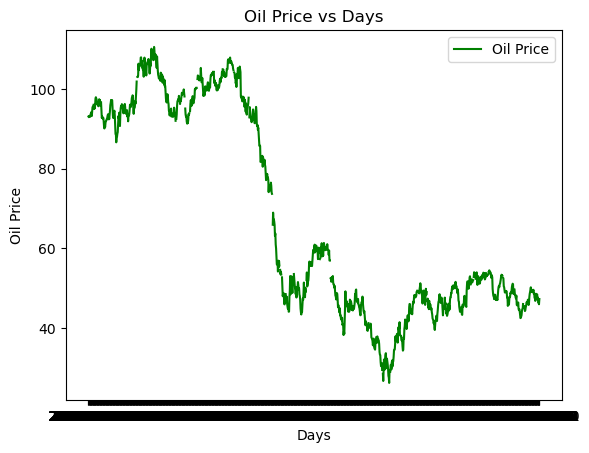

In [11]:
plt.plot(oil_df.set_index('date').dcoilwtico, color='green', label=f"Oil Price")
plt.title("Oil Price vs Days")
plt.xlabel("Days")
plt.ylabel("Oil Price")
plt.legend()
plt.show()

#### 날짜별로 그룹화, 날짜별 매출 및 거래의 평균값 확인

In [13]:
train_data_per_date = train_df.groupby('date').agg({'sales': 'mean'}).reset_index()
train_data_per_date['weekly_avg_sales'] = train_data_per_date['sales'].ewm(span=7, adjust=False).mean()

train_data_per_date.head()

,date,sales,weekly_avg_sales
0,2013-01-01,1.409438,1.409438
1,2013-01-02,278.390807,70.654780
2,2013-01-03,202.840197,103.701135
3,2013-01-04,198.911154,127.503640
4,2013-01-05,267.873244,162.596041


In [14]:
transactions_per_day = trans_df.groupby('date').agg({'transactions': 'mean'}).reset_index()
transactions_per_day['weekly_avg_transactions'] = transactions_per_day['transactions'].ewm(span=7, adjust=False).mean()

transactions_per_day.head()

,date,transactions,weekly_avg_transactions
0,2013-01-01,770.000000,770.000000
1,2013-01-02,2026.413043,1084.103261
2,2013-01-03,1706.608696,1239.729620
3,2013-01-04,1706.391304,1356.395041
4,2013-01-05,2034.195652,1525.845194


#### sales와 oil price 비교

In [15]:
fig=make_subplots()

fig.add_trace(go.Scatter(x=train_data_per_date.date,y=train_data_per_date.sales,name="Sales"))
fig.add_trace(go.Scatter(x=train_data_per_date.date,y=train_data_per_date.weekly_avg_sales,name="Weekly Sales"))


fig.add_trace(go.Scatter(x=oil_df.date,y=oil_df.dcoilwtico,name="Oil Price"))

fig.update_layout(autosize=True,width=900,height=500,title_text="Variation of Sales and Oil Price Through Time")
fig.update_xaxes(title_text="Days")
fig.update_yaxes(title_text="Prices")
fig.show()

#### transaction과 oil price 비교

In [16]:
fig=make_subplots()

fig.add_trace(go.Scatter(x=transactions_per_day.date,y=transactions_per_day.transactions,name="Transactions"))
fig.add_trace(go.Scatter(x=transactions_per_day.date,y=transactions_per_day.weekly_avg_transactions,name="Weekly Transactions"))

fig.add_trace(go.Scatter(x=oil_df.date,y=oil_df.dcoilwtico,name="Oil Price"))

fig.update_layout(autosize=True,width=900,height=500,title_text="Variation Transactions and Oil Price Through Time")
fig.update_xaxes(title_text="Days")
fig.update_yaxes(title_text="Prices")
fig.show()

#### 변수 간 상관관계 확인을 위한 행렬

In [17]:
oil_df['sales'] = train_data_per_date['sales']
oil_df['transactions'] = transactions_per_day['transactions']

oil_df.corr()

,dcoilwtico,sales,transactions
dcoilwtico,1.000000,-0.500805,0.04319
sales,-0.500805,1.000000,0.37651
transactions,0.043190,0.376510,1.00000


그래프와 상관행렬 분석을 통해 oil과 transaction 사이 강한 상관관계가 없음을 알 수있다.

oil price와 sales는 약간의 반비례관계를 띈다.

# Training the model

In [34]:
oil_df = pd.read_csv('oil.csv')
train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)
sample_subm = pd.read_csv('sample_submission.csv')
holi_df = pd.read_csv('holidays_events.csv')
store_df =  pd.read_csv('stores.csv')
trans_df = pd.read_csv('transactions.csv')

### Explore the training data

In [35]:
basic_eda(train_df)

-------------------------------TOP 5 RECORDS-----------------------------
          date  store_nbr      family  sales  onpromotion
id                                                       
0   2013-01-01          1  AUTOMOTIVE    0.0            0
1   2013-01-01          1   BABY CARE    0.0            0
2   2013-01-01          1      BEAUTY    0.0            0
3   2013-01-01          1   BEVERAGES    0.0            0
4   2013-01-01          1       BOOKS    0.0            0
-------------------------------INFO--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 137.4+ MB
None
-------------------------------Describe----------------------------------
         

In [36]:
print(min(train_df['date']))
print(max(train_df['date']))

2013-01-01
2017-08-15


#### numerical, categorical 열 찾기

numerical data 표준화하거나 categorical data를 인코딩할 때 사용하기 위함.

In [37]:
object_cols = [cname for cname in train_df.columns 
               if train_df[cname].dtype == "object" 
               and cname != "date"]

print("Categorical variables:")
object_cols 

Categorical variables:


['family']

In [38]:
num_cols = [cname for cname in train_df.columns 
            if train_df[cname].dtype in ['int64', 'float64']]

print("Numerical variables:")
num_cols 

Numerical variables:


['store_nbr', 'sales', 'onpromotion']

In [39]:
all_cols = num_cols + object_cols
print(all_cols)

['store_nbr', 'sales', 'onpromotion', 'family']


### Taking care of Categorical Features
피처로 사용하기 위해 categorical columns를 numerical로 변환하기 

In [40]:
ordinal_encoder = OrdinalEncoder()
train_df[object_cols] = ordinal_encoder.fit_transform(train_df[object_cols])
train_df

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,0.0,0.000,0
1,2013-01-01,1,1.0,0.000,0
2,2013-01-01,1,2.0,0.000,0
3,2013-01-01,1,3.0,0.000,0
4,2013-01-01,1,4.0,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,28.0,438.133,0
3000884,2017-08-15,9,29.0,154.553,1
3000885,2017-08-15,9,30.0,2419.729,148


### Scaling of Numerical Features
leaning algorithm 더 잘 사용하기 위해 numerical data 표준화하기

In [41]:
scaler = MinMaxScaler(feature_range=(0,1))

for col in num_cols:
    scaled_data = scaler.fit_transform(train_df[col].values.reshape(-1,1))
    train_df[col] = pd.Series(scaled_data.flatten())

train_df.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,0.0,0.0,0.0,0.0
1,2013-01-01,0.0,1.0,0.0,0.0
2,2013-01-01,0.0,2.0,0.0,0.0
3,2013-01-01,0.0,3.0,0.0,0.0
4,2013-01-01,0.0,4.0,0.0,0.0


### Grouping the Data
데이터 날짜별로 분리

In [27]:
'''
train_df = train_df.groupby(['date']).agg({'sales':'mean', 'onpromotion':'mean'})
train_df.tail()
''''''

,sales,onpromotion
date,,
2017-08-11,0.003718,0.010738
2017-08-12,0.003566,0.006295
2017-08-13,0.003895,0.007030
2017-08-14,0.003424,0.006091
2017-08-15,0.003432,0.008031


In [28]:
x_train = train_df.copy()
y_train = train_df.sales.copy()
x_train.head()

,sales,onpromotion
date,,
2013-01-01,0.000011,0.0
2013-01-02,0.002232,0.0
2013-01-03,0.001626,0.0
2013-01-04,0.001595,0.0
2013-01-05,0.002148,0.0


In [29]:
y_train.head()

date
2013-01-01    0.000011
2013-01-02    0.002232
2013-01-03    0.001626
2013-01-04    0.001595
2013-01-05    0.002148
Name: sales, dtype: float64

## baseline model

In [42]:
def get_last_available_week(df):
    # Get date of the last available week
    df = df.assign(diff_from_max_train_ds=df.ds - (df.ds.min() - timedelta(days=1))) # - datetime.strptime(df.ds.min(), "%Y-%m-%d"))
    df = df.assign(nb_weeks=np.ceil(df.diff_from_max_train_ds.dt.days/7).astype('int'))
    df = df.assign(last_week_ds=df.ds - (df.nb_weeks*7).map(lambda x: timedelta(x)))
    
    return df

def get_yhat(df):
    df = pd.merge(df, 
    df[['ds', 'store_nbr', 'family', 'prop_family_per_store']].rename(columns={'prop_family_per_store': 'last_week_prop_family_per_store'}),
         left_on = ['last_week_ds', 'store_nbr', 'family'],
         right_on=['ds', 'store_nbr', 'family'],
         how='left'
        ).drop(['diff_from_max_train_ds', 'nb_weeks', 'last_week_ds', 'ds_y'], axis=1).rename(columns={'ds_x': 'ds'})

    df = df.assign(yhat=df.yhat_store_nbr * df.last_week_prop_family_per_store)
    
    return df

In [43]:
train_df

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,0.000000,0.0,0.000000,0.000000
1,2013-01-01,0.000000,1.0,0.000000,0.000000
2,2013-01-01,0.000000,2.0,0.000000,0.000000
3,2013-01-01,0.000000,3.0,0.000000,0.000000
4,2013-01-01,0.000000,4.0,0.000000,0.000000
...,...,...,...,...,...
3000883,2017-08-15,0.150943,28.0,0.003513,0.000000
3000884,2017-08-15,0.150943,29.0,0.001239,0.001350
3000885,2017-08-15,0.150943,30.0,0.019402,0.199730


In [44]:
# Cross validation
val_df = train_df[(train_df.date >= '2017-08-01') & (train_df.date <= '2017-08-15')]

val_df = pd.merge(get_last_available_week(val_df)[['id', 'date', 'last_week_ds', 'store_nbr', 'family', 'y']],
                    train_df[['ds', 'store_nbr', 'family', 'y']],
                    left_on=['last_week_ds', 'store_nbr', 'family'], right_on=['ds', 'store_nbr', 'family'], how='left').rename(columns={'ds_x': 'ds', 'y_x': 'y', 'y_y': 'yhat'})


print('RMSLE: %s' %rmsle(val_df.yhat, val_df.y))

AttributeError: 'DataFrame' object has no attribute 'ds'

## Transforming the Input data into Time-Series data
training data를 time-series accepte sequences로 변환해 모델에 공급해야 함

keras Timeseries Generator를 사용해 시퀀스 생성

In [26]:
num_feature_input = len(x_train.columns)
history_input = 30

"""
length: Number of past time steps to be included, 
batch_size: The amount of predicted days. Here we have 1 since we are trying to predict the next day using the last 30 days.
"""
generator = TimeseriesGenerator(x_train, y_train, length=history_input, batch_size = 1)

# Print the first sequence, you should see 30 past day (x) for 1 predicted day (y)
for i in range(len(generator)):
    x, y = generator[i]
    print('%s => %s' % (x, y))
    break

[[[1.13010918e-05 0.00000000e+00]
  [2.23218011e-03 0.00000000e+00]
  [1.62640375e-03 0.00000000e+00]
  [1.59490009e-03 0.00000000e+00]
  [2.14784868e-03 0.00000000e+00]
  [2.33838232e-03 0.00000000e+00]
  [1.51239286e-03 0.00000000e+00]
  [1.43241371e-03 0.00000000e+00]
  [1.36124486e-03 0.00000000e+00]
  [1.16529593e-03 0.00000000e+00]
  [1.30368188e-03 0.00000000e+00]
  [1.81447030e-03 0.00000000e+00]
  [2.09065264e-03 0.00000000e+00]
  [1.31992821e-03 0.00000000e+00]
  [1.34594081e-03 0.00000000e+00]
  [1.43241432e-03 0.00000000e+00]
  [1.20361619e-03 0.00000000e+00]
  [1.33244809e-03 0.00000000e+00]
  [1.94586381e-03 0.00000000e+00]
  [2.07469660e-03 0.00000000e+00]
  [1.40030279e-03 0.00000000e+00]
  [1.33282550e-03 0.00000000e+00]
  [1.27452842e-03 0.00000000e+00]
  [1.11248811e-03 0.00000000e+00]
  [1.30496464e-03 0.00000000e+00]
  [1.86190230e-03 0.00000000e+00]
  [1.93664941e-03 0.00000000e+00]
  [1.28443510e-03 0.00000000e+00]
  [1.19007398e-03 0.00000000e+00]
  [1.26464150e

In [27]:
print(len(generator))

1654


In [28]:
def Multi_Step_LSTM_model():
    
    # Use Keras sequential model
    model = Sequential()    
    
    # First LSTM layer with Dropout regularisation; Set return_sequences to True to feed outputs to next layer
    model.add(LSTM(units = 50, activation='relu', return_sequences = True, input_shape = (history_input, num_feature_input))) 
    model.add(Dropout(0.2))
    
    # Second LSTM layer with Dropout regularisation; Set return_sequences to True to feed outputs to next layer
    model.add(LSTM(units = 50,  activation='relu', return_sequences = True))                                    
    model.add(Dropout(0.2))
    
    # Final LSTM layer with Dropout regularisation; Set return_sequences to False since now we will be predicting with the output layer
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    # The output layer with linear activation to predict Open stock price
    model.add(Dense(units=1, activation = "linear"))
    
    return model

In [29]:
model = Multi_Step_LSTM_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

#### compiler와 optimatization mechanism 설정
널리 사용되고 일반 경사하강법보다 잘 수행되는 Adam optimazation method 사용.

In [30]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])
model.fit_generator(generator, steps_per_epoch=len(generator), epochs=20, verbose=2)

Epoch 1/20
1654/1654 - 68s - loss: 3.9938e-06 - accuracy: 0.0000e+00 - 68s/epoch - 41ms/step
Epoch 2/20
1654/1654 - 61s - loss: 2.0437e-06 - accuracy: 0.0000e+00 - 61s/epoch - 37ms/step
Epoch 3/20
1654/1654 - 61s - loss: 1.7536e-06 - accuracy: 0.0000e+00 - 61s/epoch - 37ms/step
Epoch 4/20
1654/1654 - 1086s - loss: 1.4877e-06 - accuracy: 0.0000e+00 - 1086s/epoch - 656ms/step
Epoch 5/20
1654/1654 - 64s - loss: 1.5700e-06 - accuracy: 0.0000e+00 - 64s/epoch - 39ms/step
Epoch 6/20
1654/1654 - 58s - loss: 1.4819e-06 - accuracy: 0.0000e+00 - 58s/epoch - 35ms/step
Epoch 7/20
1654/1654 - 61s - loss: 1.5226e-06 - accuracy: 0.0000e+00 - 61s/epoch - 37ms/step
Epoch 8/20
1654/1654 - 61s - loss: 1.5513e-06 - accuracy: 0.0000e+00 - 61s/epoch - 37ms/step
Epoch 9/20
1654/1654 - 62s - loss: 1.5237e-06 - accuracy: 0.0000e+00 - 62s/epoch - 37ms/step
Epoch 10/20
1654/1654 - 62s - loss: 1.6198e-06 - accuracy: 0.0000e+00 - 62s/epoch - 37ms/step
Epoch 11/20
1654/1654 - 60s - loss: 1.5408e-06 - accuracy: 0.000

### Save and Load model if needed
밑 코드 두개 주석처리. save & load를 원하면 주석처리 해제 후 사용.

a) save the model

In [31]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("model2.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model2.h5")
# print("Saved model to disk")

b) load the model

In [32]:
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

In [ ]:
model_history = model.fit(x_train, y_train,             
                          epochs = epochs,                          
                          batch_size=512,
                          shuffle=True)

# Predicting on Test data (WIP)
test 데이터 예측에 도움을 주기 위해 train 데이터에서 지난 30일 보관

In [33]:
# split a univariate sequence into samples
def split_sequence(data, days_past, days_future):
    X, y = list(), list()
    
    for i in range(len(data)):        
        # find the end of this pattern
        end_ix = i + days_past
        out_end_ix = end_ix + days_future
        
        # check if we are beyond the sequence
        if out_end_ix > len(data):
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix], data[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [34]:
full_dataset = pd.concat([train, test], ignore_index=True, sort=False)
full_dataset = full_dataset.iloc[3000887-5:,:]
full_dataset

,sales,onpromotion,date,store_nbr,family


In [35]:
full_dataset = full_dataset.groupby(['date']).agg({'sales':'mean', 'onpromotion':'mean'})
full_dataset

,sales,onpromotion
date,,


In [36]:
test

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1
3029396,2017-08-31,9,PREPARED FOODS,0
3029397,2017-08-31,9,PRODUCE,1
